#                                              Logistic Regression

Lets say I wanted to build a model on Shooting Baskets that takes in “distance from the basket” in feet and spits out the probability that I will make the shot.

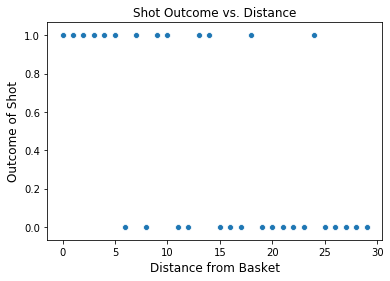

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# My data (makes and misses vs. distance)
makes = [1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0]    # <- if you made the shot then this is 1
distance = [i for i in range(30)]

df = pd.DataFrame()
df['y'] = makes
df['x'] = distance

# scatter of just outcome (makes) and x variable (distances)
ax = sns.scatterplot(x='x', y='y', data=df)
ax.set_xlabel("Distance from Basket",fontsize=12)
ax.set_ylabel("Outcome of Shot",fontsize=12)
plt.title('Shot Outcome vs. Distance')
plt.savefig(fname='bball_scatter1', dpi=200)
plt.show()

From the above data we can observe that, the further I get from the basket, the less accuracy I shoot. So we need to build a model when given a small distance, it should predict a high probability and when given a large distance it should predict a low probability.

Since logistic regression works a lot like good old linear regression. So let’s start with the familiar linear regression equation: Y = B0+(B1 * X)

In logistic regression the output Y is in log odds. Odds is just another way of expressing the probability of an event, P(Event).

***Odds = P(Event) / [1-P(Event)]***

Example: Let’s say I shot 100 free throws and made 70. Based on this sample, my probability of making a free throw is 70%. My odds of making a free throw can be calculated as: **Odds = 0.70 / (1–0.70) = 2.333**

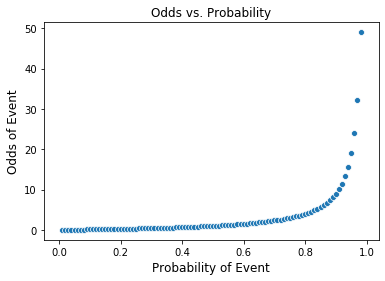

In [15]:
prob = [i/100 for i in range(1,99)]
odds = [i/(1-i) for i in prob]

odds_df = pd.DataFrame()
odds_df['prob'] = prob
odds_df['odds'] = odds

ax = sns.scatterplot(x='prob', y='odds', data=odds_df)
ax.set_xlabel("Probability of Event",fontsize=12)
ax.set_ylabel("Odds of Event",fontsize=12)
plt.title('Odds vs. Probability')
plt.savefig(fname='odds_scatter1', dpi=150)
plt.show()

From the above we can infer that the Probability of Odds range from 0 -> +ve Infinity

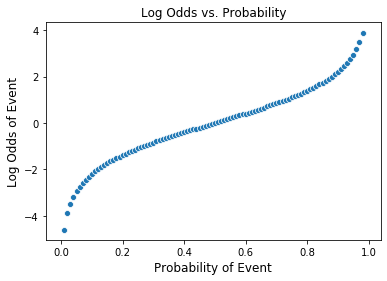

In [16]:
log_odds = [np.log(i) for i in odds]
odds_df['log_odds'] = log_odds

ax = sns.scatterplot(x='prob', y='log_odds', data=odds_df)
ax.set_xlabel("Probability of Event",fontsize=12)
ax.set_ylabel("Log Odds of Event",fontsize=12)
plt.title('Log Odds vs. Probability')
plt.savefig(fname='odds_scatter2', dpi=150)
plt.show()

If we apply natural log of the odds, then we get log odds which are unbounded (ranges from negative to positive infinity) and roughly linear across most probabilities!

We can write our logistic regression equation as: ***Z = B0+(B1 * distance_from_basket) where Z = log(odds_of_making_shot)***

And to get probability from Z, which is in log odds, we apply the sigmoid function as Probability of making shot = 1 / [1 + e^(-Z)]

#### EStimation of the coefficients B0 & B1

###### Cost Function

n the linear regression world where we have a continuous target variable (and we can simply square the difference between the actual outcome and our prediction to compute the contribution to cost of each prediction). But here we are dealing with a target variable that contains only 0s and 1s.

Assume that we made our first shot from right underneath the basket — that is [Shot Outcome = 1 | Distance from Basket =0].

For this say our model spit out a probablity of 0.95 which means it expects me to hit 95% of my shots from 0 feet.

In the actual data, I took only one shot from 0 feet and made it so my actual (sampled) accuracy from 0 feet is 100%.

So the model was wrong because the answer according to our data was 100% but it predicted 95%. But it was only slightly wrong so we want to penalize it only a little bit. 
The penalty in this case is **-log(0.95) = 0.0513**. Notice how close it is to just taking the difference of the actual probability and the prediction.

Now let’s pretend that we built a crappy model and it spits out a probability of 0.05. In this case we are massively wrong and our cost would be: **-log(0.05) = 2.996**. This cost is a lot higher. The model was pretty sure that I would miss and it was wrong so we want to strongly penalize it; we are able to do so thanks to taking the natural log.

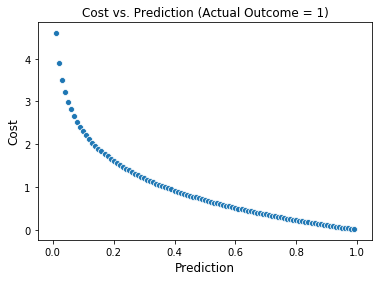

In [32]:
cost_1 = []
cost_0 = []
for i in range(1,100):
    cost_1.append(-np.log(i/100))
    cost_0.append(-np.log(1-i/100))
cost_df = pd.DataFrame()
cost_df['cost_1'] = cost_1
cost_df['cost_0'] = cost_0
cost_df['pred'] = [i/100 for i in range(1,100)]

ax = sns.scatterplot(x='pred', y='cost_1', data=cost_df)
ax.set_xlabel("Prediction",fontsize=12)
ax.set_ylabel("Cost",fontsize=12)
plt.title('Cost vs. Prediction (Actual Outcome = 1)')
plt.savefig(fname='cost_scatter1', dpi=150)
plt.show()

The above plot shows how the cost relates to our prediction (the first plot depicts how cost changes relative to our prediction when the Actual Outcome =1).

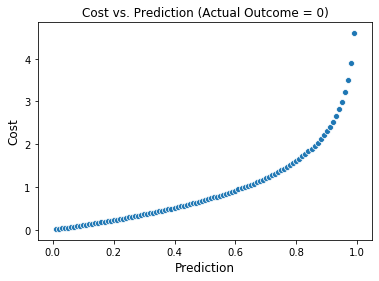

In [33]:
ax = sns.scatterplot(x='pred', y='cost_0', data=cost_df)
ax.set_xlabel("Prediction",fontsize=12)
ax.set_ylabel("Cost",fontsize=12)
plt.title('Cost vs. Prediction (Actual Outcome = 0)')
plt.savefig(fname='cost_scatter0', dpi=150)
plt.show()

The above plot shows the same but when the Actual Outcome = 0.

So for a given observation, we can compute the cost as: 
    
**If Actual Outcome = 1, then Cost = -log(pred_prob)**

**Else if Actual Outcome = 0, then Cost = -log(1-pred_prob)**

**Where pred_prob is the predicted probability that pops out of our model.**

And for our entire data set we can compute the total cost by:

    Computing the individual cost of each observation using the procedure above.
    Summing up all the individual costs to get the total cost.

This total cost is the number we want to minimize, and we can do so with a gradient descent optimization. In other words we can run an optimization to find the values of B0 and B1 that minimize total cost.

In [35]:
# initial guess of parameter values
b0 = 0.2
b1 = -0.5

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

# function for getting probability predictions given a beta0 and beta1
def get_predictions(b0, b1):
    predictions = []
    raw_predictions= []
    for i in distance:
        predictions.append(sigmoid(b0 + b1*i))    # <- notice that after you predict, you end up with log odds
                                                  #    so you need to put the output in a sigmoid function
                                                  #    to convert to probabilities
        raw_predictions.append(b0 + b1*i)
    return predictions, raw_predictions

# function to compute the cost function <- we need to minimize this cost function to fit the logit
def compute_cost(predictions):
    costs = []
    for i, val in enumerate(makes):
        if val == 1:
            costs.append(-np.log(predictions[i])) # notice the error is computed differently depending on y (makes)
        else:
            costs.append(-np.log(1-predictions[i]))
    # the sum of costs is the model's current error
    cost = sum(costs)
    return cost

# now we need to minimize cost (in reality this is done with gradient descent but I brute forced it)
# let's look at how we did with our first guess
pred1, pred1_raw = get_predictions(b0, b1)
cost1 = compute_cost(pred1)
print('Our initial measure of error is pretty high: ', cost1)

# let's loop through a bunch of beta0s and beta1s to try to lower the cost
lowest_cost = cost1
best_params = [b0, b1]
for i in range(-30, 31):
    b0_guess = i/10
    for j in range(-10,11):
        b1_guess = j/10
        new_pred, raw_pred = get_predictions(b0_guess, b1_guess)
        new_cost = compute_cost(new_pred)
        if new_cost < lowest_cost:
            lowest_cost = new_cost
            print('Found a way to lower the error to: ', new_cost)
            best_params = [b0_guess, b1_guess]

print('\nMy estimate for Beta0: ', best_params[0])
print('My estimate for Beta1: ', best_params[1])

Our initial measure of error is pretty high:  54.76484150983305
Found a way to lower the error to:  50.49046541550897
Found a way to lower the error to:  40.45762054721229
Found a way to lower the error to:  35.4143547242043
Found a way to lower the error to:  34.7589145531905
Found a way to lower the error to:  34.149748437046114
Found a way to lower the error to:  33.58885448013974
Found a way to lower the error to:  33.07816616283167
Found a way to lower the error to:  32.61953672326395
Found a way to lower the error to:  32.21472397315151
Found a way to lower the error to:  31.865375771483453
Found a way to lower the error to:  31.752499593060868
Found a way to lower the error to:  31.573016355770942
Found a way to lower the error to:  30.765585695392666
Found a way to lower the error to:  29.807840331289206
Found a way to lower the error to:  28.881602748488795
Found a way to lower the error to:  27.98932831578225
Found a way to lower the error to:  27.133580881588
Found a way to 

After optimization we found the optimal values for our model as B0 = 2.5 and B1 = -0.2.
We can take a look at our slope coefficient, B1, which measure the impact that distance has on my shooting accuracy. We estimated B1 to be -0.2. This means that for every 1 foot increase in distance, the log odds of me making the shot decreases by 0.2. B0, the y-intercept, has a value of 2.5. This is the model’s log odds prediction when I shoot from 0 feet (right next to the basket).

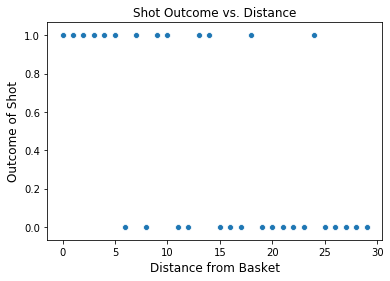

In [37]:
# throw my predictions and actuals into a df for plotting
df_final = pd.DataFrame()
predictions, raw_predictions = get_predictions(best_params[0], best_params[1])
df_final['prediction'] = predictions
df_final['prediction_raw'] = raw_predictions
df_final['actual'] = makes
df_final['distance'] = distance

# scatter of just outcome (makes) and x variable (distances)
ax = sns.scatterplot(x='distance', y='actual', data=df_final)
ax.set_xlabel("Distance from Basket",fontsize=12)
ax.set_ylabel("Outcome of Shot",fontsize=12)
plt.title('Shot Outcome vs. Distance')
plt.savefig(fname='bball_scatter1', dpi=150)
plt.show()

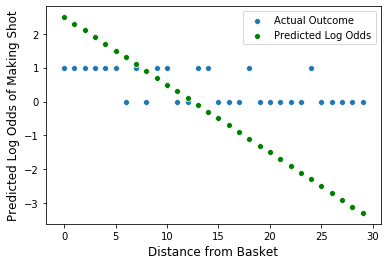

In [38]:
# scatter with log odds and predicted probability
sns.scatterplot(x='distance', y='actual', data=df_final)
ax = sns.scatterplot(x='distance', y='prediction_raw', data=df_final, color='g')
ax.set_xlabel("Distance from Basket",fontsize=12)
ax.set_ylabel("Predicted Log Odds of Making Shot",fontsize=12)
plt.legend(labels=['Actual Outcome', 'Predicted Log Odds'])
plt.savefig(fname='bball_scatter2', dpi=150)
plt.show()

We are almost done! Since Z is in log odds, we need to use the sigmoid function to convert it into probabilities:
**Probability of Making Shot = 1 / [1 + e^(-Z)]**

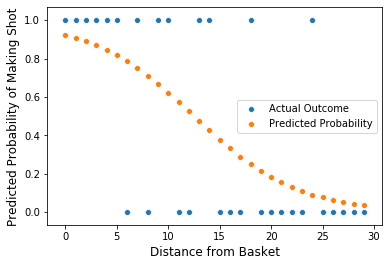

In [39]:
# scatter with predicted probability
sns.scatterplot(x='distance', y='actual', data=df_final)
ax = sns.scatterplot(x='distance', y='prediction', data=df_final)
ax.set_xlabel("Distance from Basket",fontsize=12)
ax.set_ylabel("Predicted Probability of Making Shot",fontsize=12)
plt.legend(labels=['Actual Outcome', 'Predicted Probability'])
plt.savefig(fname='bball_scatter3', dpi=150)
plt.show()

#### Understandig MLE in Logistic Regression

What is MLE?

Maximum Likelihood Estimation is a method for estimating parameters. Every time we fit a statistical or machine learning model, we are estimating parameters. 
A single variable linear regression has the equation: Y = B0 + (B1*X)

Our goal when we fit this model is to estimate the parameters B0 and B1 given our observed values of Y and X. 
We use Ordinary Least Squares (OLS), not MLE, to fit the linear regression model and estimate B0 and B1. 
But similar to OLS, MLE is a way to estimate the parameters of a model, given what we observe.

MLE asks the question, “Given the data that we observe (our sample), what are the model parameters that maximize the likelihood of the observed data occurring?”

The outputs of a logistic regression are class probabilities. But our data comes in the form of 1s and 0s, not probabilities. For example, if I shot a basketball 10 times from varying distances, my Y variable, the outcome of each shot, would look something like (1 represents a made shot): y = [0, 1, 0, 1, 1, 1, 0, 1, 1, 0]. And my X variable, the distance (in feet) from the basket of each shot, would look like: X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]. 

How can we go from 1s and 0s to probabilities?

We can think of each shot as the outcome of a binomially distributed random variable. this means that each shot is its own trial (like a single coin toss) with some underlying probability of success.

**Except that we are not just estimating a single static probability of success; rather we are estimating the probability of success conditional on how far we are from the basket when we shoot the ball.**

So we can reframe our problem as a conditional probability (y = the outcome of the shot):
P(y | Distance from Basket).

In order to use MLE, we need some parameters to fit. In a single variable logistic regression, those parameters are the regression betas: B0 and B1.

You can think of B0 and B1 as hidden parameters that describe the relationship between distance and the probability of making a shot. For certain values of B0 and B1, there might be a strongly positive relationship between shooting accuracy and distance. For others, it might be weakly positive or even negative (Steph Curry). If B1 was set to equal 0, then there would be no relationship at all.

For each set of B0 and B1, we can use Monte Carlo simulation to figure out the probability of observing the data. The probability we are simulating for is the probability of observing our exact shot sequence (y=[0, 1, 0, 1, 1, 1, 0, 1, 1, 0], given that Distance from Basket=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) for a guessed set of B0, B1 values.

**P(y=[0, 1, 0, 1, 1, 1, 0, 1, 1, 0] | Dist=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])** for a given B0 and B1

By trying a bunch of different values, we can find the values for B0 and B1 that maximize P(y=[0, 1, 0, 1, 1, 1, 0, 1, 1, 0] | Dist=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]). Those would be the MLE estimates of B0 and B1.

Obviously in logistic regression and with MLE in general, we’re not going to be brute force guessing. Rather, we create a cost function that is basically an inverted form of the probability that we are trying to maximize. This cost function is inversely proportional to P(y=[0, 1, 0, 1, 1, 1, 0, 1, 1, 0] | Dist=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) and like it, the value of the cost function varies with our parameters B0 and B1. We can find the optimal values for B0 and B1 by using gradient descent to minimize this cost function.

### Implementation of Logistic Regression in Python

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [41]:
# Download the dataset
# Source of dataset - https://www.kaggle.com/rakeshrau/social-network-ads

data = pd.read_csv('Social_Network_Ads.csv')
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


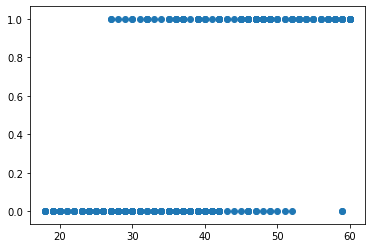

In [43]:
# Visualizing the dataset
plt.scatter(data['Age'], data['Purchased'])
plt.show()

# Divide the data to training set and test set
X_train, X_test, y_train, y_test = train_test_split(data['Age'], data['Purchased'], test_size=0.20)

In [44]:
# why do we normalise the data - 
# https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff


# Creating the logistic regression model

# Helper function to normalize data
def normalize(X):
    return X - X.mean()

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

# Method to make predictions
def predict(X, b0, b1):
    z = b0 + b1*i
    return np.array([sigmoid(b0 + b1*x) for x in X])

# Method to train the model
def logistic_regression(X, Y):

    X = normalize(X)

    # Initializing variables
    b0 = 0
    b1 = 0
    L = 0.001
    epochs = 300

    for epoch in range(epochs):
        y_pred = predict(X, b0, b1)
        D_b0 = -2 * sum((Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b0
        D_b1 = -2 * sum(X * (Y - y_pred) * y_pred * (1 - y_pred))  # Derivative of loss wrt b1
        # Update b0 and b1
        b0 = b0 - L * D_b0
        b1 = b1 - L * D_b1
    
    return b0, b1

# Training the model
b0, b1 = logistic_regression(X_train, y_train)

print(b0, b1)

-1.0722862474811035 0.2090715238577348


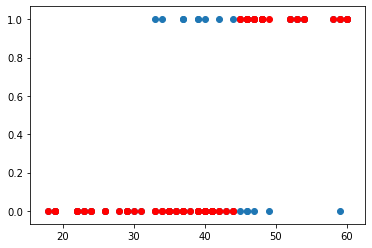

Accuracy = 0.8125


In [47]:
# Making predictions
X_test_norm = normalize(X_test)
y_pred = predict(X_test_norm, b0, b1)
y_pred = [1 if p >= 0.5 else 0 for p in y_pred]

plt.clf()
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred, c="red")
plt.show()

# The accuracy
accuracy = 0
for i in range(len(y_pred)):
    if y_pred[i] == y_test.iloc[i]:
        accuracy += 1
print(f"Accuracy = {accuracy / len(y_pred)}")

In [56]:
final_df = pd.DataFrame(
    {'X_test': X_test,
     'y_test': y_test,
     'y_pred': y_pred,
     'Diff': (y_test - y_pred)
    })

final_df.head()

,X_test,y_test,y_pred,Diff
373,59,1,1,0
250,44,0,0,0
139,19,0,0,0
228,40,0,0,0
166,22,0,0,0


In [58]:
final_df.loc[~final_df['Diff'] == 0]

,X_test,y_test,y_pred,Diff
201,49,0,1,-1
205,47,0,1,-1
376,46,0,1,-1
238,46,0,1,-1
64,59,0,1,-1
298,45,0,1,-1
